# Building Machine Learning Models

## Loading Clean Dataset

We will load the dataset that we have processed previously, yesterday.

In [1]:
import pandas as pd

df = pd.read_csv("dataset/clean-dataset.csv")

## Problem Definition

Let's assume this.

Suppose that the air quality sensor for particles less than 10 microns (PM10) has begun to malfunction, and we want to use historical data to estimate the `PM10` values using data from our functioning sensors. 

If you include the particle matter sensor readings in the pair plot, a strong linear relationship between `PM2.5` and `PM10` can be observed. This makes sense, considering that either measure indicates a higher level of pollution in the air. As such, including the `PM2.5` measurements will likely enhance our model's performance.

### Dataset glossary

* `NO`, `NO2`, and `NOX` refer to the levels of nitric oxide, nitrogen dioxide, and combined forms of nitrogen oxides, respectively.
* `O3` denotes the levels of ozone.
* `PM10` and `PM2.5` refer to the levels of particulate matter in the air with an aerodynamic diameter of less than 10μm and 2.5μm, respectively.
* `SO2` represents the levels of sulfur dioxide.
* `WIND` and `WINDS` stand for the direction and speed of the wind, respectively.

##### Regression plot

<Axes: xlabel='PM10', ylabel='PM2.5'>

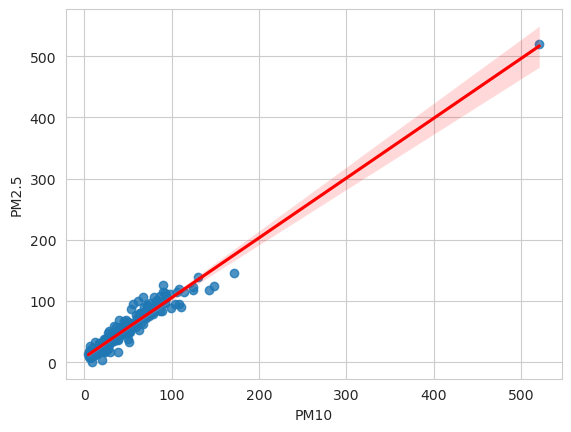

In [2]:
import seaborn as sns

sns.set_style("whitegrid") # showing grid in our plots - easier to read
sns.regplot(data=df, x="PM10", y="PM2.5", line_kws = {"color": "red"}, ci=99)

##### Pairplot

/home/faiz/anaconda3/envs/work/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


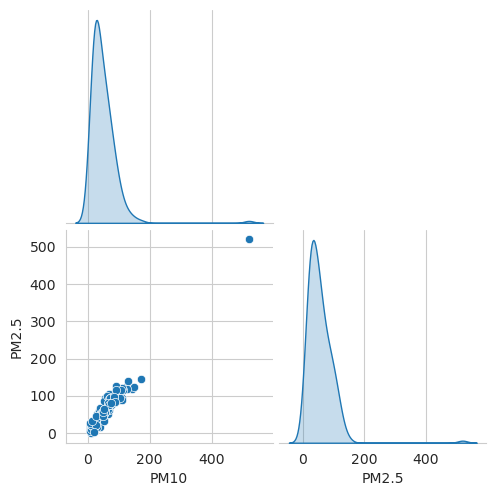

In [3]:
import seaborn as sns

sns.pairplot(
    df[["PM10", "PM2.5"]],
    diag_kind='kde', 
    corner=True
)

With this in mind, we are going to define a variable `x`, which represents our model's input, and a variable `y`, which is our model's output (or in this case, the target, since we want the model's output to match this). Let's visualize the first sample. Here is `x` — the model's input:

In [4]:
x = df[["NO", "NO2", "NOX", "O3", "PM2.5", "SO2", "WIND", "WINDS"]]

In [5]:
x.head()

,NO,NO2,NOX,O3,PM2.5,SO2,WIND,WINDS
0,64.600000,22.600000,92.200000,8.460000,15.000000,22.000000,47.720640,1.920000
1,51.000000,28.090909,83.636364,15.381818,27.818182,6.818182,49.164558,2.000000
2,66.000000,23.909091,94.545455,10.572727,28.636364,14.909091,50.890575,2.090909
3,96.090909,26.272727,127.363636,9.200000,16.090909,15.545455,31.543421,2.427273
4,135.272727,26.090909,166.090909,10.218182,20.363636,7.363636,45.036002,2.527273


Now, let's examine `y`, which is the *model* target variable:

In [6]:
y = df[["PM10"]]

In [7]:
y.head()

,PM10
0,15.800000
1,22.818182
2,28.363636
3,23.363636
4,15.272727


## Training and Validation Sets

In machine learning, it is common practice to divide your dataset into a training set, a validation set, and occasionally a test set. For the purpose of this workshop, we will exclude the test set. Furthermore our dataset is relatively small.


Keeping these sets consistent is crucial for comparing different models' performance without the data split influencing the results. The training set is utilised to **train and adjust a model's parameters, while the validation set is used to evaluate the model's performance**. 

In other words, while the validation set influences decision-making about models, it is not used for learning the model parameters.

For this purpose we will utilise Scikit-learn's `train_test_split(...)` function to separate our data into these individual sets. The default dataset split ratio is 75:25 which 75% is used for training and 25% for validation. Ideally, we would want to keep at least 70% of the dataset for training and use the remaining for validation and testing. You can pass`test_size=0.x` argument when defining the test split.

*Please install `scikit-learn` module if you haven't using Anaconda Navigator or Anaconda Prompt.*

In [40]:
from sklearn.model_selection import train_test_split

# Split dataset x to train (X_train) and validation set (X_val). We will use 30% of the data to validate our model.
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.3)

Let's check their structure

In [9]:
print("X_train #rows : %d #columns : %d" % (X_train.shape[0],X_train.shape[1])) 
print("X_val #rows : %d #columns : %d" % (X_val.shape[0],X_val.shape[1])) 

X_train #rows : 148 #columns : 8
X_val #rows : 64 #columns : 8


As shown in the output, the default split provides us with 159 samples for training and 53 samples for validation. 

## Normalising Data

It is evident in the dataset, wind direction values are confined to the range `[0, 360]`, representing all possible wind directions. However, other measurements do not necessarily fall within this same range. For instance, `O3` rarely exceeds values of 40, while `NOX` can reach up to 600.

Furthermore, measurements of gases, particles, directions, and speeds are measured on different scale. To standardise - or normalise the data, we can adjust it to fit within the range of `[0, 1]`. Our chosen approach to achieve this uses the formula:

$$ \frac{X-min}{max-min} $$


With this transformation, an $X$ equal to the max results in an output of 1, while an $X$ equal to the min provides an output of 0. Importantly, this transformation process compares each feature (i.e., each sensor) individually.

It is crucial to only use the $min$ and $max$ values from the training data for normalisation. This will simulate how the model will perform in a real-world production environment. Using statistics from the validation data could potentially bias the training process - something we definitely want to avoid. While training, the model should not have any knowledge of the validation data (or of the test set, if one is being used).

To begin, we need to establish the $min$ and $max$ values.

In [29]:
X_max, X_min = X_train.max(), X_train.min()
y_max, y_min = y_train.max(), y_train.min()

In [11]:
X_max

NO       509.272727
NO2       95.090909
NOX      507.818182
O3        44.290909
PM2.5    519.272727
SO2       30.454545
WIND     358.570176
WINDS      4.454545
dtype: float64

With all `X_train`, `y_train`, `X_val` and `y_val` dataframes ready, we can now initiate the transformation. The good thing about *DataFrame* is that mathematical operations, like the transformation we need, can be vectorised. 

### What does vectorisation mean?

Vectorisation enables us to apply the transformation to all columns simultaneously (and it is fast!), without having to undertake the process for each separate column. This aspect is also apparent when we print out `X_max` above.

Let's normalise the dataset using the formula above:

In [75]:
X_train_norm = (X_train-X_min)/(X_max-X_min)
y_train_norm = (y_train-y_min)/(y_max-y_min)
X_val_norm = (X_val-X_min)/(X_max-X_min)
y_val_norm = (y_val-y_min)/(y_max-y_min)

In [41]:
import numpy as np

X_train_norm = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
y_train_norm = (y_train-np.min(y_train))/(np.max(y_train)-np.min(y_train))
X_val_norm = (X_val-np.min(X_val))/(np.max(X_val)-np.min(X_val))
y_val_norm = (y_val-np.min(y_val))/(np.max(y_val)-np.min(y_val))

..and verify their maximum and minimum values.

In [76]:
print(X_val_norm.min())

NO       0.000000
NO2      0.045173
NOX      0.001790
O3       0.025079
PM2.5    0.011037
SO2     -0.005831
WIND     0.036977
WINDS    0.029724
dtype: float64


In [71]:
print(X_train_norm.min())

0.0


## Artificial Neural Networks (ANN)

We are now ready to construct our first model. 

To understand the functioning of the model, let's start by exploring the theory behind artificial neural networks.

An artificial neural network aims to *approximate* a mathematical function. With large and perhaps complex datasets, it is impractical to formulate handwritten rules for classifying or predicting outcomes from specific inputs. For instance, when examining pet images, we do not want to devise specific rules to classify the images as either dogs or cats. 

The fundamental concept of a neural network is depicted in a simplified form below:

![ANN concept](assets/ann-concept.jpeg)

In the above diagram, each column of blue nodes represents a layer, with red and green nodes indicating the input and output respectively. Typically, every node in one layer is fully connected, meaning that each node has a link to every other node between layers. For the sake of simplicity, we only display the connections for the first layer here. 

A connection between nodes involves a multiplicative weight $w$ and an additive bias $b$. A typical node sums up all the incoming connections, followed by an activation function like a `tanh` function or `softmax`.

Thus, a node in the first layer (assuming the output variable is $z$) could be seen as follows:

$$ z=tanh(w_1x_1+b_1 + w_2x_2+b_2+w_3x_3+b_3)$$

The `tanh` function limits the output to lie within the range `[-1, 1]`. Specifically, the activation function is important as it introduces non-linearity to the model, enabling it to learn complex functions which could not be achieved through mere matrix multiplication. That is, a neural network without non-linearities could simply be replaced by a basic matrix multiplication.

The number of layers and their widths are considered the *hyperparameters* of a model. Other hyperparameters include *batch size*, which refers to the number of data samples the model learns from in each forward and backward step during training, and the *learning rate*, which indicates how much the model learns at each step of the data passing through the network. The *activation* function, which we discussed earlier, is another hyperparameter, as is the choice of *solver*, which defines how the learning rate changes over time. 

The number of *epochs* refers to the number of times the entire dataset is batched and the model learns from it. Additional hyperparameters exist and complex models are likely to necessitate more varied choices of hyperparameters.

It is a good idea to first construct a basic model that you can effectively understand and explain to others. Depending on how well that basic model performs, it can be fine-tuned before being progressed into more sophisticated, state-of-the-art models. In both academic and professional scenarios, simple, explainable models tend to perform better than poorly implemented, unnecessarily complicated ones.

## Model 1: Multilayer Perceptron

We will build a relatively straightforward model using a neural network via the `sklearn.neural_network.MLPRegressor`. MLP stands for Multi-Layer Perceptron, a specific type of artificial neural network.

We use a regressor since we want our model to predict a continuous numerical value (as opposed to predicting distinct categories, such as classifying images as either a dog or a cat).

In [78]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(hidden_layer_sizes=(32, 64))
nn.fit(X_train_norm, y_train_norm.values.ravel())

MLPRegressor(hidden_layer_sizes=(32, 64))

#### Predict validation data set

In [79]:
y_pred = nn.predict(X_val_norm)

In [81]:
print("Model %s" % nn)
print("Predictions: %d" % y_pred.shape)

Model MLPRegressor(hidden_layer_sizes=(32, 64))
Predictions: 64


### Visualise predictions

We will now create a scatter plot to visualise our model's predictions against the actual values. 

In this plot, a perfect model would result in all data points lining up diagonally — this would signify that all predictions accurately match their corresponding labels.

Text(0.5, 1.0, 'Predictions vs Labels')

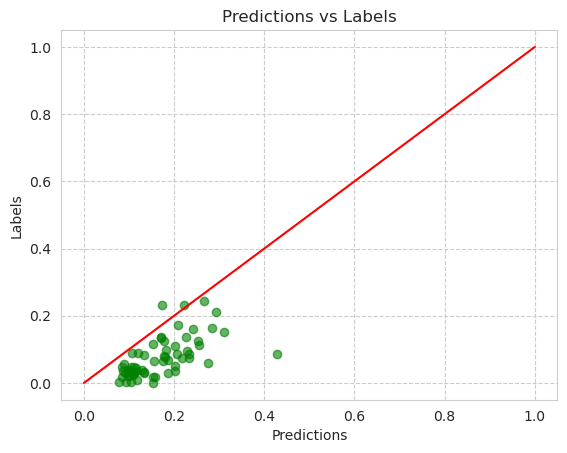

In [82]:
import matplotlib.pyplot as plt

plt.plot([0, 1], [0, 1], c='red')
plt.scatter(y_pred, y_val_norm, alpha=0.6,  c="green")
plt.grid(linestyle='--')

# Labels
plt.xlabel('Predictions')
plt.ylabel('Labels')
plt.title('Predictions vs Labels')

## Scoring Metrics

Scikit-learn provides a range of convenient metrics to assess the performance of a model. Here are a few widely used ones:

* `r2_score` represents the coefficient of determination, where an ideal score is 1.
* `explained_variance_score` denotes the proportion of variation in a dataset that a model explains, with 1 being perfect performance.
* `mean_squared_error` is the average of the squares of the differences between predicted and actual values. A mean squared error of 0 signifies perfect accuracy.
* `mean_absolute_error` functions similarly to mean squared error, but the absolute values of the differences between predicted and actual values are used instead. In this case, an ideal performance score is 0.

In [83]:
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error

print("R2 Score: %.4f" % r2_score(y_val_norm, y_pred))
print("Explained Variance Score: %.4f" % explained_variance_score(y_val_norm, y_pred))
print("MSE: %.4f" % mean_squared_error(y_val_norm, y_pred))
print("MAE: %.4f" % mean_absolute_error(y_val_norm, y_pred))

R2 Score: -2.2889
Explained Variance Score: 0.0858
MSE: 0.0115
MAE: 0.0932


### Tracking Experiment Results

We will define a few functions at this stage, which will be reused later in this workshop. These functions will generate scatter plots to represent predictions and will print four metrics based on the expected predictions

In [59]:
def plot_preds(y_pred, y_val):
    plt.plot([0, 1], [0, 1], c='red')
    plt.scatter(y_pred, y_val, alpha=0.6,  c="green")
    plt.grid(linestyle='--')

    # Labels
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.title('Predictions vs Labels')

def calc_metrics(y_pred, y_val):
    r2 = r2_score(y_pred, y_val)
    ev = explained_variance_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    return r2, ev, mse, mae

Before we proceed, let's ensure our results are stored for future reference. We will create lists of experiment names along with the calculated values, and save this data in a DataFrame. This will allow us to effectively visualise our findings at the end of this workshop.

In [60]:
r2, ev, mse, mae = calc_metrics(y_pred, y_val_norm)

In [61]:
experiments = ['BasicNN']*4
metric_names = ['R2', 'Explained Variance', 'MSE', 'MAE']
metric_vals = [r2, ev, mse, mae]
print(metric_vals)

[-11.323068597230126, 0.4999705720695651, 0.07086968905522147, 0.2055792835540426]


## Model 2: Optimising Hyperparameters

We could potentially enhance our model's performance by tweaking some of the crucial hyperparameters defined previously. Specifically, we will try a deeper and wider network architecture, a `batch_size` of 32, and using `tanh` as the activation function. 

Let's modify these parameters and evaluate the impact on our model.

In [52]:
opt_nn = MLPRegressor(
    hidden_layer_sizes=(64, 128, 256), 
    batch_size=32,
    activation='tanh',
    solver='adam',
    random_state=7,
    )

opt_nn.fit(X_train_norm, y_train_norm.values.ravel())

MLPRegressor(activation='tanh', batch_size=32,
             hidden_layer_sizes=(64, 128, 256), random_state=7)

In [53]:
y_pred = opt_nn.predict(X_val_norm)
print("Model: %s" % opt_nn)
print("Predictions: %d" % y_pred.shape)

Model: MLPRegressor(activation='tanh', batch_size=32,
             hidden_layer_sizes=(64, 128, 256), random_state=7)
Predictions: 64


Visualise and calculate scores

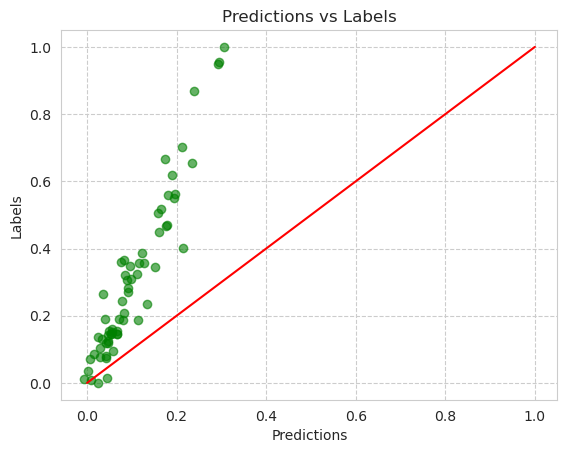

In [54]:
plot_preds(y_pred, y_val_norm)
r2, ev, mse, mae = calc_metrics(y_pred, y_val_norm)

In [55]:
print("R2 Score: %.4f" %r2)
print("Explained Variance Score: %.4f" % ev)
print("MSE: %.4f" % mse)
print("MAE: %.4f" % mae)

R2 Score: -0.2090
Explained Variance Score: 0.5000
MSE: 0.0709
MAE: 0.2056


As demonstrated, model performance has significantly improved. Notably, the `tanh` activation function appears instrumental in enhancing the model's effectiveness. Explore further to discover if any other trends contribute to this performance enhancement.

Let's save this as *AdvancedNN*

In [22]:
experiments.extend(['AdvancedNN']*4)
metric_names.extend(['R2', 'Explained Variance', 'MSE', 'MAE'])
metric_vals.extend([r2, ev, mse, mae])

## Model 3: Gradient Boosting

One viable alternative to a standard but hyperparameter-optimised neural network is the `GradientBoostingRegressor`, an implementation of gradient boosting from the Scikit-learn library. This model is an example of an additive model, implying that it is a **composition of smaller, simpler models**. The term 'additive' in this context refers to *ensemble* methods, which are aggregations of weak models that deliver good performance when combined.

As an illustration of extreme parameter tuning, let's set the number of estimators to 2,000 and the maximum depth to 20. Altering these values can significantly influence model performance; however, please note that these changes will also require more computational resources.

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(
    n_estimators=2000,
    max_depth=20,
    learning_rate=1e-3,
    random_state=7
)

gb.fit(X_train_norm, y_train_norm.values.ravel())

GradientBoostingRegressor(learning_rate=0.001, max_depth=20, n_estimators=2000,
                          random_state=7)

In [24]:
y_pred = gb.predict(X_val_norm)
print("Model: %s" % gb)
print("Predictions: %d" % y_pred.shape)

Model: GradientBoostingRegressor(learning_rate=0.001, max_depth=20, n_estimators=2000,
                          random_state=7)
Predictions: 53


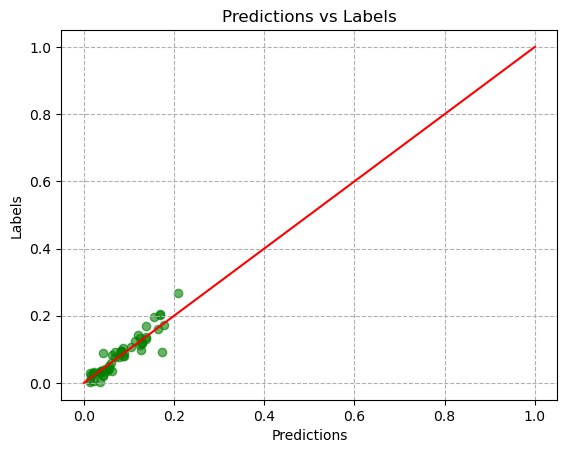

In [25]:
plot_preds(y_pred, y_val_norm)
r2, ev, mse, mae = calc_metrics(y_pred, y_val_norm)

In [26]:
print("R2 Score: %.4f" %r2)
print("Explained Variance Score: %.4f" % ev)
print("MSE: %.4f" % mse)
print("MAE: %.4f" % mae)

R2 Score: 0.8640
Explained Variance Score: 0.8645
MSE: 0.0005
MAE: 0.0157


This model performs quite well. Let's save this as *GBModel*

In [27]:
experiments.extend(['GBModel']*4)
metric_names.extend(['R2', 'Explained Variance', 'MSE', 'MAE'])
metric_vals.extend([r2, ev, mse, mae])

## Model 4: Random Forest

Random Forest Regression is a versatile machine-learning technique for predicting numerical values. It combines the predictions of multiple decision trees to reduce overfitting and improve accuracy. Every decision tree has high variance, but when we combine all of them in parallel then the resultant variance is low as each decision tree gets perfectly trained on that particular sample data, and hence the output doesn’t depend on one decision tree but on multiple decision trees. 

In [32]:
from sklearn.ensemble import RandomForestRegressor

# Fitting Random Forest Regression to the dataset
rf = RandomForestRegressor(n_estimators=10, random_state=0)

# Fit the regressor with x and y data
rf.fit(X_train_norm, y_train_norm.values.ravel())

RandomForestRegressor(n_estimators=10, random_state=0)

In [33]:
y_pred = rf.predict(X_val_norm)
print("Model: %s" % rf)
print("Predictions: %d" % y_pred.shape)

Model: RandomForestRegressor(n_estimators=10, random_state=0)
Predictions: 53


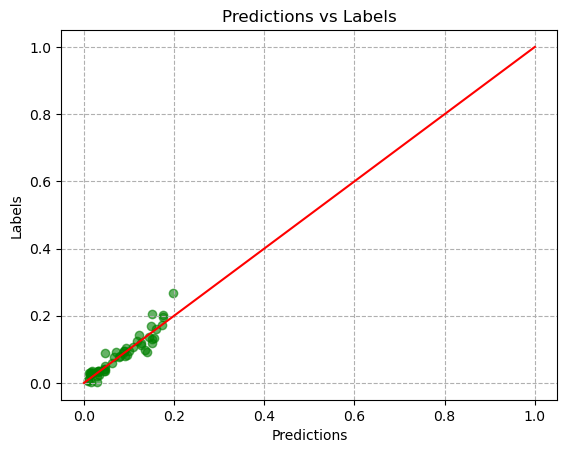

In [34]:
plot_preds(y_pred, y_val_norm)
r2, ev, mse, mae = calc_metrics(y_pred, y_val_norm)

In [35]:
experiments.extend(['RFModel']*4)
metric_names.extend(['R2', 'Explained Variance', 'MSE', 'MAE'])
metric_vals.extend([r2, ev, mse, mae])

## Comparing Models

Comparing models using the same train/validate data split helps in determining the most suitable model for a given problem. 

However, it is equally important to test an array of models, beginning with simpler ones and gradually moving towards complex models. Utilizing an overly complex model for simple problems can lead to increased resource usage and complications in explaining any anomalies that may arise.

As a rule, the simpler the model that still achieves adequate performance, the better.

Now, let's examine the performances of our models. We will create a DataFrame df_res using the lists we compiled earlier, to store and compare the results of our model experiments.

In [36]:
df_res = pd.DataFrame()
df_res['Experiment'] = experiments
df_res['Metric'] = metric_names
df_res['Value'] = metric_vals

df_res.head()

,Experiment,Metric,Value
0,BasicNN,R2,0.634591
1,BasicNN,Explained Variance,0.634682
2,BasicNN,MSE,0.001290
3,BasicNN,MAE,0.029116
4,AdvancedNN,R2,0.881013


Lastly, we will visualise our results. We create two separate plots: one for metrics that perform better the closer they are to 1, and another for those that perform better when closer to 0. This distinction will assist us in better interpreting our performance metrics.

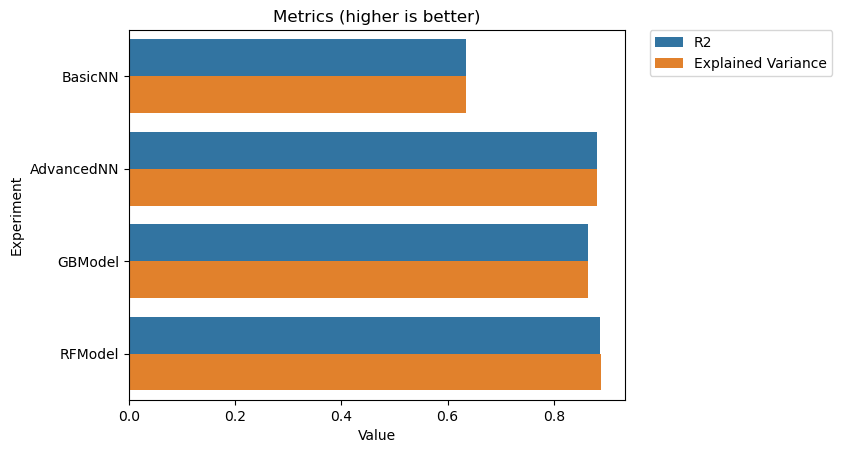

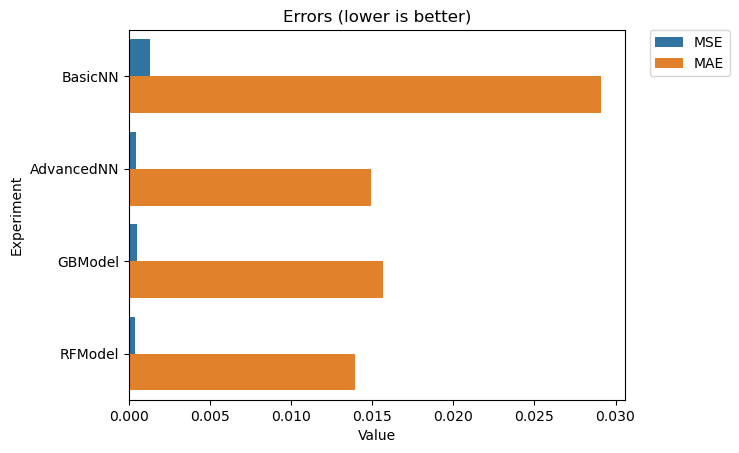

In [48]:
plt.figure()
sns.barplot(
    data=df_res[df_res.Metric.isin(["R2", "Explained Variance"])],
    orient='h',
    x='Value',
    y='Experiment',
    hue='Metric'
).set(title="Metrics (higher is better)")

# place the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.figure()
sns.barplot(
    data=df_res[df_res.Metric.isin(["MAE", "MSE"])],
    orient='h', # horizontal  
    x='Value',
    y='Experiment',
    hue='Metric',
).set(title="Errors (lower is better)")

# place the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Upon examination, it seems that the `RFModel` is our top performer overall. It delivers the highest metric scores and the lowest errors, although the difference compared to `AdvancedNN` and `GBModel` is minimal and likely negligible.